In [8]:
import cv2
import numpy as np
def read_vkitti_png_flow(flow_fn):
    # “Convert from .png to (h, w, 2) (flow_x, flow_y) float32 array”
    # read png to bgr in 16 bit unsigned short

    bgr = cv2.imread(flow_fn, cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)
    h, w, _c = bgr.shape
    assert bgr.dtype == np.uint16 and _c == 3
    # b == invalid flow flag == 0 for sky or other invalid flow
    invalid = bgr[..., 0] == 0
    # g,r == flow_y,x normalized by height,width and scaled to [0;2**16 – 1]
    out_flow = 2.0 / (2**16 - 1.0) * bgr[..., 2:0:-1].astype('f4') - 1
    out_flow[..., 0] *= w - 1
    out_flow[..., 1] *= h - 1
    out_flow[invalid] = np.nan # or another value (e.g., np.nan)
    return out_flow

In [9]:
ff = read_vkitti_png_flow('/mnt/data/datasets/virtual-kitti/Scene01/clone/frames/forwardFlow/Camera_0/flow_00000.png').transpose(2, 0, 1)[np.newaxis, ...]
bf = read_vkitti_png_flow('/mnt/data/datasets/virtual-kitti/Scene01/clone/frames/backwardFlow/Camera_0/backwardFlow_00001.png').transpose(2, 0, 1)[np.newaxis, ...]
img0 = cv2.imread("/mnt/data/datasets/virtual-kitti/Scene01/clone/frames/rgb/Camera_0/rgb_00000.jpg", cv2.IMREAD_COLOR).transpose(2, 0, 1)[np.newaxis, ...]
img1 = cv2.imread("/mnt/data/datasets/virtual-kitti/Scene01/clone/frames/rgb/Camera_0/rgb_00001.jpg", cv2.IMREAD_COLOR).transpose(2, 0, 1)[np.newaxis, ...]
img2 = cv2.imread("/mnt/data/datasets/virtual-kitti/Scene01/clone/frames/rgb/Camera_0/rgb_00002.jpg", cv2.IMREAD_COLOR).transpose(2, 0, 1)[np.newaxis, ...]

In [10]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import numpy
def backwardwarp(x, flo):
    """
    warp an image/tensor (im2) back to im1, according to the optical flow

    x: [B, C, H, W] (im2)
    flo: [B, 2, H, W] flow

    """
    B, C, H, W = x.size()
    # mesh grid 
    xx = torch.arange(0, W).view(1,-1).repeat(H,1)
    yy = torch.arange(0, H).view(-1,1).repeat(1,W)
    xx = xx.view(1,1,H,W).repeat(B,1,1,1)
    yy = yy.view(1,1,H,W).repeat(B,1,1,1)
    grid = torch.cat((xx,yy),1).float()

    if x.is_cuda:
        grid = grid.cuda()
    vgrid = Variable(grid) + flo

    # scale grid to [-1,1] 
    vgrid[:,0,:,:] = 2.0*vgrid[:,0,:,:].clone() / max(W-1,1)-1.0
    vgrid[:,1,:,:] = 2.0*vgrid[:,1,:,:].clone() / max(H-1,1)-1.0

    vgrid = vgrid.permute(0,2,3,1)
    print(x.shape)
    print(vgrid.shape)       
    output = nn.functional.grid_sample(x, vgrid)
    mask = torch.autograd.Variable(torch.ones(x.size())).cuda()
    mask = nn.functional.grid_sample(mask, vgrid)

    # if W==128:
        # np.save('mask.npy', mask.cpu().data.numpy())
        # np.save('warp.npy', output.cpu().data.numpy())
    
    mask[mask<0.9999] = 0
    mask[mask>0] = 1
    
    return output*mask

def weightFunc(x):
    return numpy.exp(-x)


def forwardwarp(x, flo, gain=1.0):
    """
    forward warping with splatting strategy. only consider splatting 4 corners around warp target.
    weight func is e^-x

    x: [1, C, H, W] (im1)
    flo: [1, 2, H, W] flow

    """
    _, _, H, W = flo.shape
    xx = numpy.tile(numpy.arange(0, W), (H, 1))
    yy = numpy.tile(numpy.arange(0, H)[:, numpy.newaxis], (1, W))
    grid = numpy.concatenate([xx[numpy.newaxis, ...], yy[numpy.newaxis, ...]], axis=0)
    vgrid = grid + flo.squeeze()

    ff_map = numpy.concatenate([numpy.floor(vgrid[0])[..., numpy.newaxis], numpy.floor(vgrid[1])[..., numpy.newaxis]], axis=-1)
    cf_map = numpy.concatenate([numpy.ceil(vgrid[0])[..., numpy.newaxis], numpy.floor(vgrid[1])[..., numpy.newaxis]], axis=-1)
    fc_map = numpy.concatenate([numpy.floor(vgrid[0])[..., numpy.newaxis], numpy.ceil(vgrid[1])[..., numpy.newaxis]], axis=-1)
    cc_map = numpy.concatenate([numpy.ceil(vgrid[0])[..., numpy.newaxis], numpy.ceil(vgrid[1])[..., numpy.newaxis]], axis=-1)
    allCornerMaps = [ff_map, cf_map, fc_map, cc_map]
    warpSubResults = []
    for cornerMap in allCornerMaps:
        cornerMap = cornerMap.reshape(-1, 2)
        intens = x.squeeze().transpose(1, 2, 0).reshape(-1, 3)
        distances = weightFunc(numpy.linalg.norm(cornerMap - vgrid.transpose(1, 2, 0).reshape(-1, 2), axis=1))
        maskNan = numpy.isnan(distances)  # Note: bothe cornerMap and 
        maskOutOfRangeX = numpy.logical_or(cornerMap[:, 0] >= W, cornerMap[:, 0] < 0)
        maskOutOfRangeY = numpy.logical_or(cornerMap[:, 1] >= H, cornerMap[:, 1] < 0)
        maskOuters = numpy.logical_or(maskNan, numpy.logical_or(maskOutOfRangeX, maskOutOfRangeY))
        cornerMap = cornerMap[~maskOuters].astype('int')
        intens = intens[~maskOuters]
        distances = distances[~maskOuters]
        print("distances nan: ", distances.max())
        print("intens nan: ", intens.max())
        weightedIntens = numpy.tile(distances[:, numpy.newaxis], (1, 3)) * intens
        result = numpy.zeros((H, W, 3), dtype='float')
        numpy.add.at(result, (cornerMap[:, 1], cornerMap[:, 0]), weightedIntens)
        warpSubResults.append(result)
    sumResults = numpy.zeros((H, W, 3), dtype='float')
    for subResult in warpSubResults:
        sumResults += subResult
    sumResults = sumResults * gain
    sumResults = numpy.clip(sumResults, 0, 255).astype('uint8')
    return sumResults
    

In [11]:
# sumResults = forwardwarp(img2, bf, gain=0.5)
sumResults = numpy.where(sumResults == 0, img1_backwarp, sumResults)

NameError: name 'sumResults' is not defined

torch.Size([1, 3, 375, 1242])
torch.Size([1, 375, 1242, 2])
torch.Size([1, 3, 375, 1242])
torch.Size([1, 375, 1242, 2])


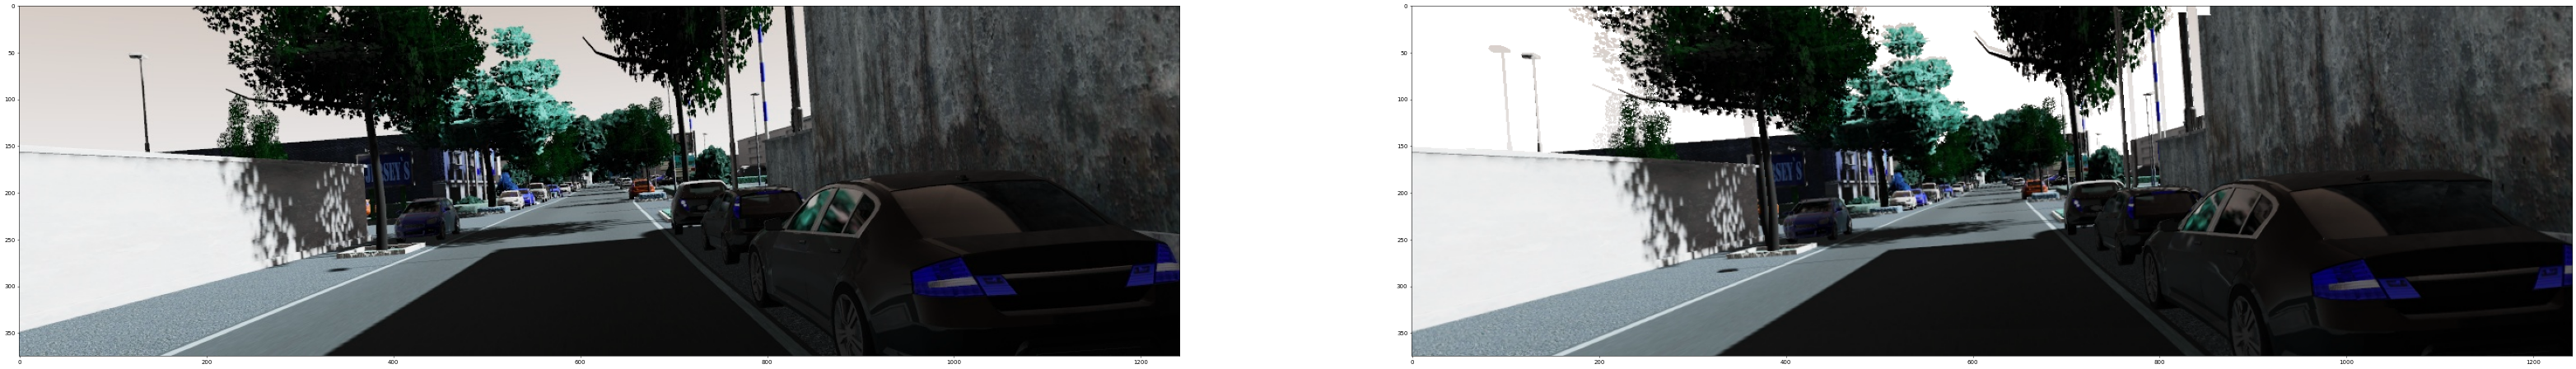

In [24]:
img1F = img1.astype('float32')
img0F = img0.astype('float32')
epsilon = 1e-5
img1F[..., ~numpy.isnan(bf[0][0])] += epsilon
img0F[..., ~numpy.isnan(ff[0][0])] += epsilon
img0d5_backwarp = backwardwarp(torch.from_numpy(img1F).cuda(), torch.from_numpy(ff * 0.9).float().cuda()).squeeze().cpu().numpy().transpose(1, 2, 0)
img0d5_forwarp = backwardwarp(torch.from_numpy(img0F).cuda(), torch.from_numpy(bf * 0.1).float().cuda()).squeeze().cpu().numpy().transpose(1, 2, 0)
img_mix = numpy.where(img0d5_backwarp == 0, img0d5_forwarp, img0d5_backwarp)

maskBackInvalid = numpy.sum(img0d5_backwarp, axis=-1) < epsilon
maskForInvalid = numpy.sum(img0d5_forwarp, axis=-1) < epsilon
# maskInvalid = numpy.clip(numpy.sum(img_mix, axis=-1), 0, 255).astype('uint8')
maskInvalid = numpy.logical_and(maskBackInvalid, maskForInvalid)
import cv2
maskInvalid = cv2.dilate(maskInvalid.view('uint8'), (3, 3), iterations = 1)
# maskInvalid = maskInvalid == 0
img_mix[maskInvalid] = 255
img_mix = img_mix.astype('uint8')

import matplotlib.pyplot as plt
plt.figure(figsize=(80, 80), dpi=50)
plt.subplot(1, 2, 1)
plt.imshow(img0.squeeze().transpose(1, 2, 0))
plt.subplot(1, 2, 2)
plt.imshow(img_mix)

In [22]:
img0d5_backwarp.shape

(375, 1242, 3)